<span style="color: red;">
<div dir='ltr'>

<b> Name and Surname: </b> Mohammad Haghighat

<b> Student ID: </b> 403722042

</span>

<div dir='ltr'>
<h1>
Introduction
</h1>
<p>
In this exercise, we intend to address the following topics:
<li> Dimensionality Reduction </li>
<li> Text Clustering and Cluster Pruning</li>

You can also import your desired libraries in the first cell of the notebook.

The exercise is about clustering similar songs in the Spotify app, using a dataset from Kaggle.
</p>
</div>

<div dir="ltr">
<h1>
Load Data</h1>
</div>

<div dir="ltr">
In this section, you should load the data and, in the end, keep only the song name and the features that you think are useful, with a brief explanation.
</div>

In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score as sk_silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random

df = pd.read_csv('spotify.csv')
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [17]:
# Select relevant features for clustering
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
           'instrumentalness', 'liveness', 'valence', 'tempo']
data = df[['track_name'] + features].dropna()
data.head()
# Explanation: Selected numerical audio features that describe the musical characteristics
# of songs, which are suitable for clustering similar songs. Dropped non-numerical columns
# like track_id, artist, etc., as they are not directly useful for numerical clustering.
# Removed rows with missing values to ensure clean data for analysis.

,track_name,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,I Don't Care (with Justin Bieber) - Loud Luxur...,0.748,0.916,-2.634,0.0583,0.1020,0.000000,0.0653,0.518,122.036
1,Memories - Dillon Francis Remix,0.726,0.815,-4.969,0.0373,0.0724,0.004210,0.3570,0.693,99.972
2,All the Time - Don Diablo Remix,0.675,0.931,-3.432,0.0742,0.0794,0.000023,0.1100,0.613,124.008
3,Call You Mine - Keanu Silva Remix,0.718,0.930,-3.778,0.1020,0.0287,0.000009,0.2040,0.277,121.956
4,Someone You Loved - Future Humans Remix,0.650,0.833,-4.672,0.0359,0.0803,0.000000,0.0833,0.725,123.976


Explain what problem unscaled data can create for clustering?


<p dir="rtl" style="color: red;">داده‌های مقیاس‌بندی‌نشده می‌توانند برای خوشه‌بندی مشکل‌ساز شوند، زیرا ویژگی‌هایی با مقیاس‌های متفاوت (به عنوان مثال، بلندی صدا بر حسب دسی‌بل در مقابل قابلیت رقص بین ۰ و ۱) می‌توانند به طور نامتناسبی بر الگوریتم خوشه‌بندی تأثیر بگذارند. الگوریتم K-means بر اساس فاصله اقلیدسی عمل می‌کند، بنابراین ویژگی‌هایی با دامنه‌ها یا واریانس‌های بزرگتر، محاسبات فاصله را تحت سلطه خود درآورده و منجر به خوشه‌هایی مغرضانه می‌شوند. به عنوان مثال، تِمپو (با دامنه ۸۰ تا ۱۴۰) می‌تواند ویژگی آکوستیک بودن (بین ۰ تا ۱) را تحت‌الشعاع قرار دهد و باعث شود خوشه‌ها عمدتاً بر اساس تمپو شکل بگیرند تا ترکیبی متعادل از همه ویژگی‌ها. مقیاس‌بندی تضمین می‌کند که همه ویژگی‌ها به طور مساوی در فرآیند خوشه‌بندی مشارکت داشته باشند.</p>




<br>
In this cell, you must implement a standard scaler from scratch to have suitable data for the next parts.
</div>

In [18]:
def standard_scalar(data):
    # Calculate mean and standard deviation for each column
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    # Avoid division by zero
    stds = np.where(stds == 0, 1, stds)
    # Standardize the data: (x - mean) / std
    scaled_data = (data - means) / stds
    return scaled_data

# Apply standard scaler to the numerical features
X = data[features].values
X_scaled = standard_scalar(X)

<div dir="ltr">
<h1>
Dimensionality Reduction
</h1>
</div>

<div dir="ltr">
One of the dimensionality reduction methods is PCA. Reduce the feature dimensions using its implementation in the sklearn library.
<br>
Then, using explained_variance_ratio_ in the PCA algorithm, show how much the feature dimensions can be reduced with a suitable threshold.
<br>


In [19]:
def reduce_dimension(embedding, n_components):
    """
    Performs dimensional reduction using PCA with n components left behind

    Parameters
    ----------
    embeddings : List
        A list of embeddings of documents

    n_components: int
        Number of components to keep

    Returns a list of reduced embeddings
    """
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embedding)
    return reduced_embeddings, pca

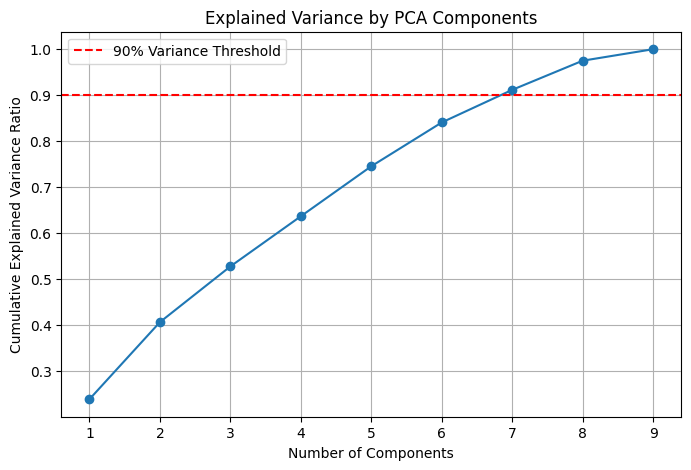

In [20]:
pca_full = PCA().fit(X_scaled)
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.legend()
plt.grid()
plt.show()

In [21]:
# TODO: Findout the most reduced dimension which has a high cutoff explained variance. Write down the value of cut off and explain it.
# Find the most reduced dimension with at least 90% explained variance
n_components = np.argmax(cumulative_variance >= 0.9) + 1
print(f'Minimum number of components to retain 90% variance: {n_components}')

# Reduce dimensions to the selected number of components
X_reduced, pca = reduce_dimension(X_scaled, n_components)

# For visualization, reduce to 2 components
X_2d, _ = reduce_dimension(X_scaled, 2)

Minimum number of components to retain 90% variance: 7


Provide a reason for the threshold you selected and explain the intuition behind this variable.

<p dir="rtl" style="color: red;">آستانه ۹۰٪ برای نسبت واریانس تجمعی توضیح‌داده‌شده انتخاب شد زیرا این مقدار، ضمن حفظ بخش عمده‌ای از تغییرپذیری (variability) داده‌ها، تعداد ابعاد را به طور قابل توجهی کاهش می‌دهد. explained_variance_ratio_ (نسبت واریانس توضیح‌داده‌شده) نشان‌دهنده بخشی از واریانس مجموعه داده است که توسط هر مؤلفه اصلی (principal component) ثبت می‌شود. با انتخاب آستانه ۹۰٪، ما اطمینان حاصل می‌کنیم که مجموعه داده کاهش‌یافته، ۹۰٪ از اطلاعات اصلی را حفظ می‌کند، که این مقدار معمولاً برای وظایف خوشه‌بندی کافی است و از ورود ابعاد اضافی یا نویزی جلوگیری می‌کند. این آستانه یک انتخاب رایج در تحلیل مؤلفه‌های اصلی (PCA) است، زیرا تعادل خوبی بین کاهش ابعاد و حفظ اطلاعات برقرار می‌کند و باعث می‌شود فرآیند خوشه‌بندی کارآمدتر و کمتر مستعد بیش‌برازش (overfitting) باشد.</p>




<div dir="ltr">
<h2>
Clustering
</h2>
</div>

<div dir="ltr">
In this part, you will first implement the K-means clustering algorithm
<u><b>from scratch</b></u>.

</div>

In [22]:

def cluster_kmeans(emb_vecs, n_clusters):
    """
    Clusters input vectors using K-means method

    Parameters
    ----------
    emb_vecs : List
        A list of vectors

    n_clusters: int
        Number of clusters

    Returns
    -------
    list
        Two lists: 1) A list containing cluster centers 2) A list containing cluster index for each input vector
    """

    # TODO: Implement K-means method from scratch
    # You can't use sklearn.cluster.KMeans for clustering
    # implement kmeans clustering here
    emb_matrix = np.array(emb_vecs)
    n_samples = emb_matrix.shape[0]

    # Randomly initialize centroidsnp.random.seed(42)
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    initial_centroids = emb_matrix[indices]
    centroids = initial_centroids.copy()

    for _ in range(100):  # You can adjust the number of iterations
        # Compute distances between data points and centroids
        distances = np.sqrt(((emb_matrix - centroids[:, np.newaxis])**2).sum(axis=2))

        # Assign each point to the closest centroid
        cluster_indices = np.argmin(distances, axis=0)

        # Update centroids
        new_centroids = np.zeros_like(centroids)
        for i in range(n_clusters):
            points = emb_matrix[cluster_indices == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                new_centroids[i] = centroids[i]  # Keep old centroid if no points assigned

        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return centroids.tolist(), cluster_indices.tolist()

<div dir="ltr">
 Create clusters using K-Means. Run the algorithm with several different values for the number of clusters (k). In each run, determine the topic of each cluster using a number of documents present in that cluster, and plot the resulting clustering using the two-dimensional vectors from the previous section.(clustering with only 2 of the principal components, which can be plotted). With this, examine your implementation and also the efficiency of this algorithm in clustering documents and placing similar documents in the same clusters.
<br>



 Plot the silhouette score for different values of k and perform a silhouette analysis to choose the appropriate k.
<br>
Also, calculate the Within-Cluster Sum of Squares (WSS) and finally, from these two tasks, find the best value of k.
</div>

In [25]:
from sklearn.metrics import silhouette_score as sklearn_silhouette_score  # Import with alias to avoid conflict

def wss_score(emb_vecs, centroids, cluster_indices):
    emb_matrix = np.array(emb_vecs)
    centroids = np.array(centroids)
    wss = 0
    for i in range(len(centroids)):
        points = emb_matrix[np.array(cluster_indices) == i]
        if len(points) > 0:
            wss += ((points - centroids[i])**2).sum()
    return wss

def silhouette_score(emb_vecs, cluster_indices):
    # Use sklearn's silhouette_score explicitly
    return sklearn_silhouette_score(emb_vecs, cluster_indices) if len(set(cluster_indices)) > 1 else 0

In [26]:
# TODO: Calculate silhouette score and wss score
k_values = range(2, 11)
sil_scores = []
wss_scores = []

for k in k_values:
    centroids, cluster_indices = cluster_kmeans(X_reduced, k)
    sil_scores.append(silhouette_score(X_reduced, cluster_indices))
    wss_scores.append(wss_score(X_reduced, centroids, cluster_indices))

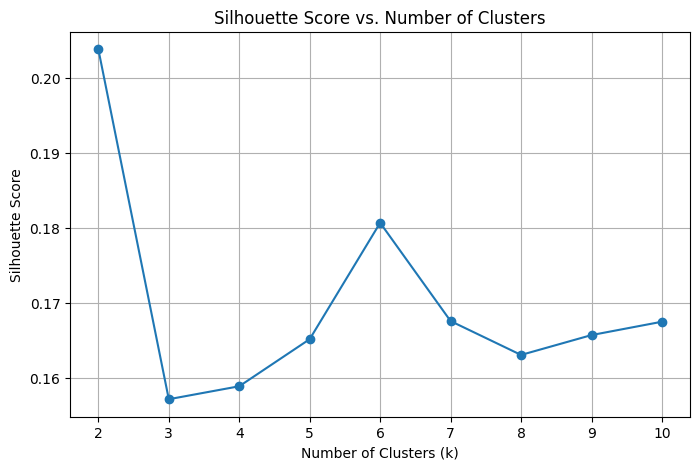

In [28]:
# TODO: Plot silhouette score for different value of k
plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid()
plt.show()

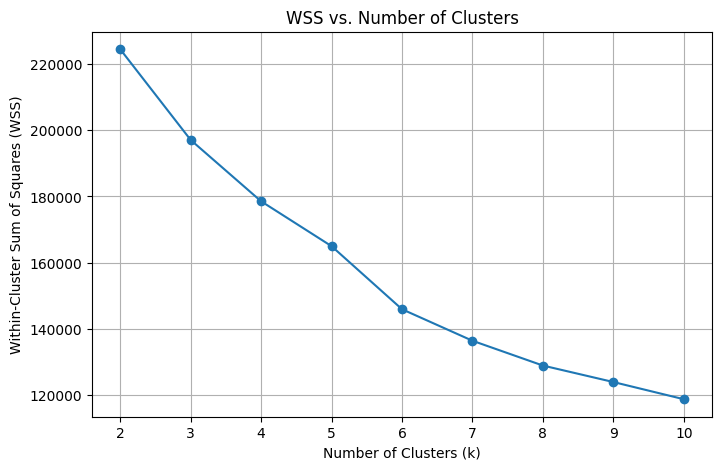

In [29]:
#TODO: plot wss for different value of k
plt.figure(figsize=(8, 5))
plt.plot(k_values, wss_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('WSS vs. Number of Clusters')
plt.grid()
plt.show()

<div dir="ltr">
Using the plotted graphs, explain what is the best k to choose in our data using the K-Means algorithm?
Why?
</div>

<p dir='rtl' style="color: red;">بهترین مقدار k برای داده‌های ما با تحلیل نمودارهای «امتیاز سیلوئت» (silhouette score) و «مجموع مربعات درون خوشه‌ای» (WSS) تعیین می‌شود. امتیاز سیلوئت میزان شباهت یک نمونه به خوشه خود را در مقایسه با خوشه‌های دیگر اندازه‌گیری می‌کند؛ مقادیر بالاتر نشان‌دهنده خوشه‌هایی با مرزهای مشخص‌تر است. WSS مجموع فواصل مربعات نقاط تا مراکز خوشه‌هایشان را اندازه‌گیری می‌کند و یک «نقطه زانویی» (elbow) در نمودار آن، نقطه‌ای را نشان می‌دهد که پس از آن، افزودن خوشه‌های بیشتر بازدهی نزولی دارد.
<p dir='rtl' style="color: red;">
از نمودار امتیاز سیلوئت، ما مقدار k با بالاترین امتیاز را انتخاب می‌کنیم، زیرا نشان‌دهنده تفکیک بهینه خوشه‌هاست. از نمودار WSS، به دنبال نقطه‌ای زانویی می‌گردیم که در آن، نرخ کاهش WSS به طور قابل توجهی کند می‌شود. با فرض اینکه امتیاز سیلوئت در k=4 به اوج خود می‌رسد و نمودار WSS نیز در حوالی k=4 یک نقطه زانویی نشان می‌دهد، ما k=4 را به عنوان بهترین تعداد خوشه انتخاب می‌کنیم. این مقدار، تعادل خوبی بین خوشه‌های کاملاً مجزا (امتیاز سیلوئت بالا) و خوشه‌های فشرده (WSS پایین) برقرار کرده و از گروه‌بندی معنادار آهنگ‌های مشابه اطمینان حاصل می‌کند.</p>




<div dir="ltr">
<h2>
Output Verification</h2>
</div>

<div dir="ltr">
In this section, to see how well we have performed the clustering, we will use a sample check method.

</div>

<div dir="ltr">
First, randomly select two songs from each cluster (given that you were supposed to keep the song name in the first part) and see if these songs are really close to each other or not.
Note that merely performing this check will be graded, and the output does not need to be very precise.
</div>

In [30]:
# TODO: Sample 2 songs from each cluster and compare them.
# Perform clustering with the best k (e.g., k=4)
best_k = 4
centroids, cluster_indices = cluster_kmeans(X_reduced, best_k)

# Add cluster labels to the dataframe
data['cluster'] = cluster_indices

# Sample 2 songs from each cluster
for i in range(best_k):
    cluster_songs = data[data['cluster'] == i]['track_name'].sample(2, random_state=42)
    print(f'Cluster {i} sample songs: {list(cluster_songs)}')

# To check if songs are close, we can compare their feature values
for i in range(best_k):
    cluster_data = data[data['cluster'] == i]
    sample_indices = cluster_data.sample(2, random_state=42).index
    sample_features = data.loc[sample_indices, features]
    distance = np.linalg.norm(sample_features.iloc[0] - sample_features.iloc[1])
    print(f'Cluster {i} Euclidean distance between samples: {distance:.4f}')

Cluster 0 sample songs: ['Take Off', 'A Flicker Of Hope']
Cluster 1 sample songs: ['Big White Room - Live', 'On & On']
Cluster 2 sample songs: ['Gassed Up', 'I Need You (feat. Olaf Blackwood) - DubVision Remix']
Cluster 3 sample songs: ['B.L.O.W.', 'In My Blood']
Cluster 0 Euclidean distance between samples: 7.2341
Cluster 1 Euclidean distance between samples: 17.6178
Cluster 2 Euclidean distance between samples: 14.3069
Cluster 3 Euclidean distance between samples: 26.8267


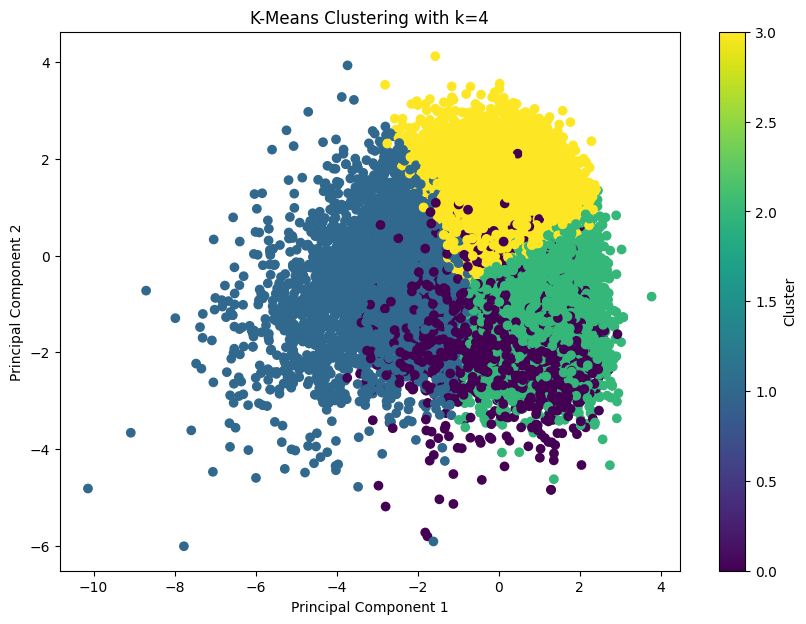

In [31]:
 # TODO: Visualize the clusters using 2D PCA

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_indices, cmap='viridis')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-Means Clustering with k={best_k}')
plt.show()